# Analyzing training NNs with quantized values

### We investigate if training on fixed point values is possible.
If so, we ask:
* What is the minimum precision needed for training?
* How does the precision affect accuracy?
* Do learning rates depend on precision, and how much? Does the conventional floating point knowledge apply here?


We first test out quantized neural networks on the MNIST dataset. We use a 784-10 network (no hidden layers), with linear, ReLU (rectified linear units), leaky ReLU, and softmax activations. 

In [49]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle

from activations import *
import lr_fraction_bar_graph
import delta_test
import train_integers

%matplotlib notebook
%load_ext autoreload
%autoreload 2


def save_object(data, filename):
    with open(filename, 'wb') as output:
        pickle.dump(data, output, pickle.HIGHEST_PROTOCOL)
        
        
def load_object(filename):
    try:
        with open(filename, 'rb') as input:
            return pickle.load(input)
    except Exception as err: 
        print err
        return None
    

# button for hiding code
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training errors after 100000 samples on different bitwidths & learning rates
Learning rates are interpreted as $\frac{1}{2^{LR}}$, so the higher the tick value, the lower the learning rate.

<IPython.core.display.Javascript object>


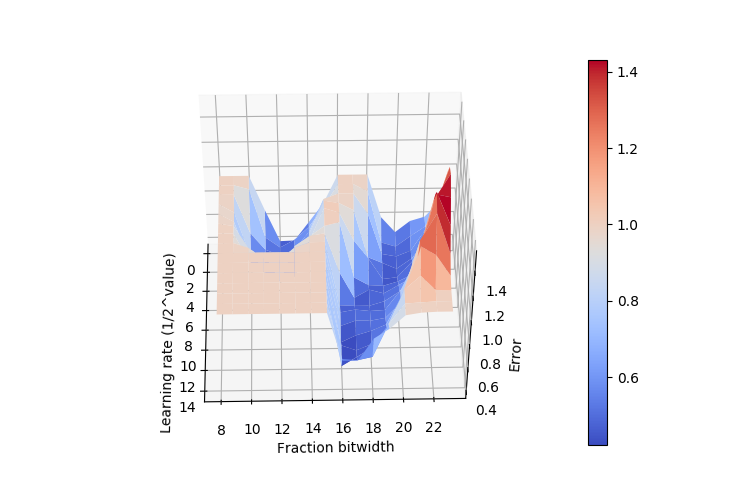

In [115]:
reload(lr_fraction_bar_graph)
lr_fraction_bar_graph.main()

## Let's get that in a bit more resolution, with a wider learning rate and fraction range 

<IPython.core.display.Javascript object>


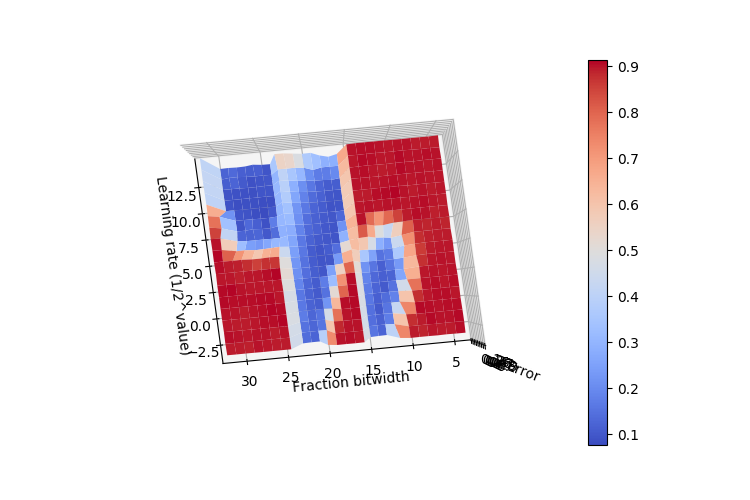

In [114]:
large_acc = load_object("large_acc.pickle")

lr = np.array([x[0] for x in large_acc]).reshape(18, 27)
fraction = np.array([x[1] for x in large_acc]).reshape(18, 27)
error = np.array([x[2] for x in large_acc]).reshape(18, 27)

fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.add_subplot(111, projection='3d')
surface = ax1.plot_surface(lr, fraction, 1-error, cmap=matplotlib.cm.coolwarm, linewidth=1, antialiased=True)

# axis labels
ax1.set_xlabel("Learning rate (1/2^value)")
ax1.set_ylabel("Fraction bitwidth")
ax1.set_zlabel("Error")

cbar = fig.colorbar(surface)



### We can notice that for some reason, training networks with 20 or 12 fraction bits works, but with 16 bits it doesn't
We analyze this behavior by observing how the error changes with iterations. The errors have a large amount of outliers, so we normalize the data at each point by taking the average of the last 1000 points.

#### We can see that the network doesn't train at all for some reason, so let's look at the deltas

<IPython.core.display.Javascript object>


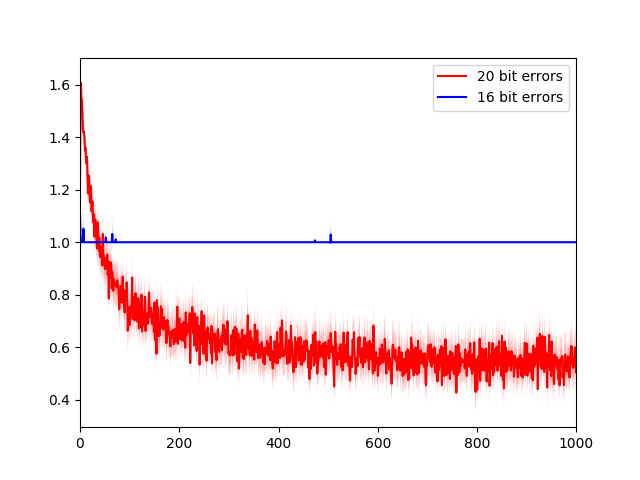

In [5]:
if "errors16" not in globals() or "errors20" not in globals():
    errors16, delta_means16, delta_vars16 = delta_test.test(16, 3, iter=100000, verbosity="none")
    errors20, delta_means20, delta_vars20 = delta_test.test(20, 3, iter=100000, verbosity="none")

    # normalize the data
    errors16 /= 2.0**16
    delta_means16 /= 2.0**16
    delta_vars16 /= 2.0**16
    errors20 /= 2.0**20
    delta_means20 /= 2.0**20
    delta_vars20 /= 2.0**20
    
def zigzag_data(data, shape):
    return data.reshape(shape).T

fig, ax1 = plt.subplots()

plot20 = sns.tsplot(data=zigzag_data(errors20, (1000, 100)), ci=[68, 95], color='r', ax=ax1)
plot16 = sns.tsplot(data=zigzag_data(errors16, (1000, 100)), ci=[68, 95], color='b', ax=ax1)

ax1.legend(handles=ax1.lines[:], labels=["20 bit errors", "16 bit errors"]);

## Lets look at the delta means for different learning rate & fraction bitwidth values

This isn't particularly informative though, but setting the $y$ axis to be logarithmic, we can see that different quantizations yield about the same relative delta. As we decrease the learning rate (bottom graphs), there is more discrepancy!

<IPython.core.display.Javascript object>


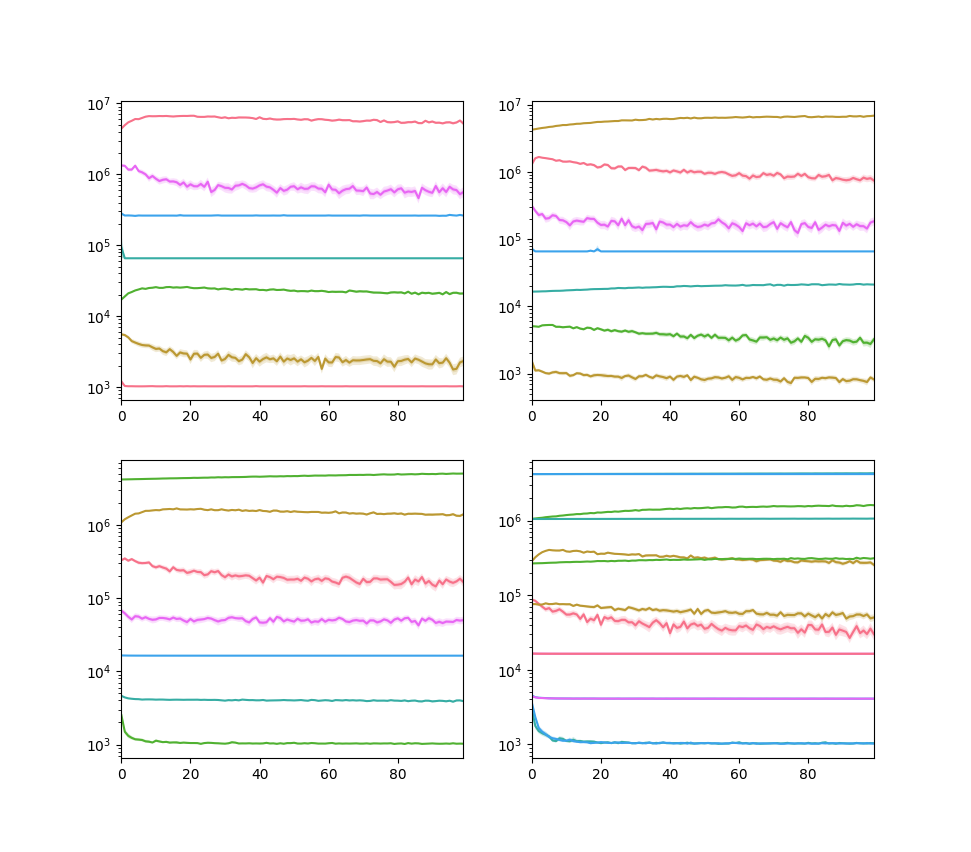

In [11]:
import pickle

with open('deltas.pickle', 'r') as input:
    deltas = pickle.load(input)
    
fig, axes = plt.subplots(2, 2, figsize=(7.5, 9))
palette = itertools.cycle(sns.color_palette("husl"))

for i in range(len(deltas)):
    if deltas[i][0] == 0:
        ax = axes[0][0]
    elif deltas[i][0] == 3:
        ax = axes[0][1]
    elif deltas[i][0] == 6:
        ax = axes[1][0]
    elif deltas[i][0] == 9:
        ax = axes[1][1]
    
    sns.tsplot(data=zigzag_data(np.array(deltas[i][2]), (100, 100)), ci=[68, 95], color=next(palette), ax=ax)

axes = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
for ax in axes:
    ax.set_yscale('log')
    ax.set_label(Delta)
    


<IPython.core.display.Javascript object>


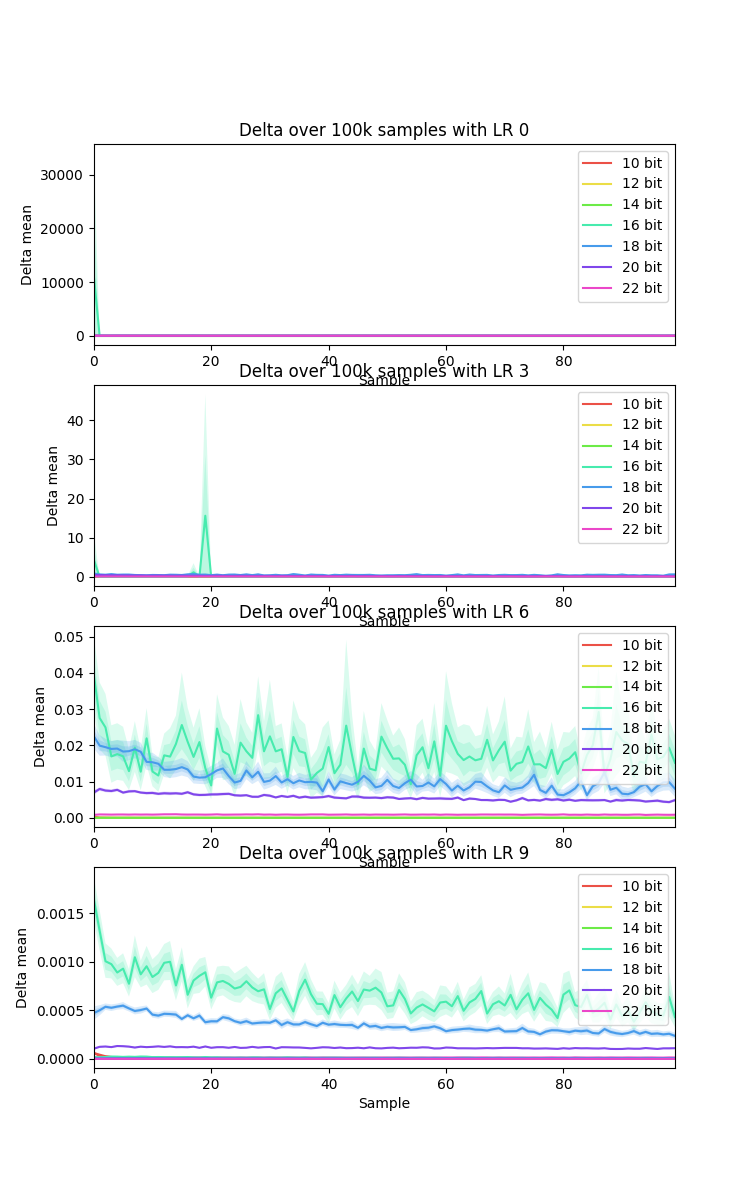

In [32]:
import pickle

with open('deltas.pickle', 'r') as input:
    deltas = pickle.load(input)
    
fig, axes = plt.subplots(4, 1, figsize=(7.5, 12))
palettes = [itertools.cycle(sns.hls_palette(7, l=.6, s=.8)) for x in range(4)] 

for i in range(len(deltas)):
#    if deltas[i][0] == 0:
#        ax = axes[0][0]
#    elif deltas[i][0] == 3:
#        ax = axes[0][1]
#    elif deltas[i][0] == 6:
#        ax = axes[1][0]
#    elif deltas[i][0] == 9:
#        ax = axes[1][1]
        
    if deltas[i][0] == 0:
        ax = axes[0]
    elif deltas[i][0] == 3:
        ax = axes[1]
    elif deltas[i][0] == 6:
        ax = axes[2]
    elif deltas[i][0] == 9:
        ax = axes[3]
    
    sns.tsplot(data=zigzag_data(np.array(deltas[i][4]) / 2**deltas[i][1], (100, 100)), \
               ci=[68, 95], color=next(palette), ax=ax)

axes = [axes[0], axes[1], axes[2], axes[3]]
for i, ax in enumerate(axes):
    ax.set_title("Delta over 100k samples with LR {}".format(3*i))
    ax.set_xlabel("Sample")
    ax.set_ylabel("Delta mean")
    ax.legend(handles=ax.lines[:], labels=["10 bit", "12 bit", "14 bit", "16 bit", "18 bit", "20 bit", "22 bit"])
    

### To analyze why the 16 fractional bit networks do not train, we compare a 20 bit one with the 16 bit one, looking at delta means and variances. 

In [29]:
deltas[0]

(0,
 10,
 array([ 1873.,  3400.,  5249., ...,  1024.,  1024.,  1024.]),
 array([ -4.99196429,  -5.2932398 , -16.84132653, ...,   0.        ,
          0.        ,   0.        ]),
 array([ 1431.28577726,  2258.7796992 ,  3964.17711865, ...,     0.        ,
            0.        ,     0.        ]))

<IPython.core.display.Javascript object>


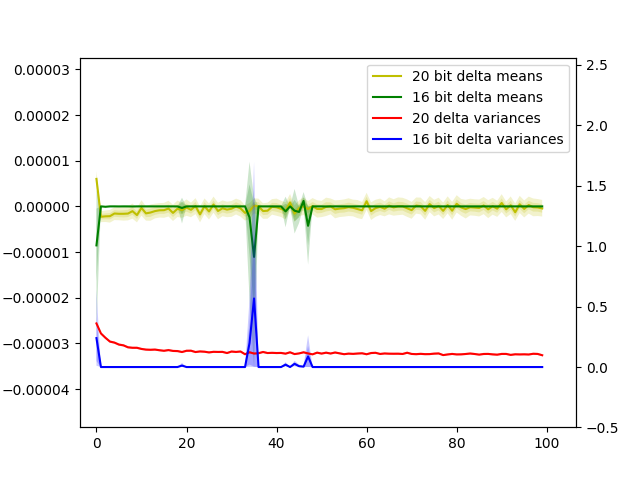

In [39]:
fig, ax1 = plt.subplots()

sns.tsplot(data=zigzag_data(delta_means20, (100, 1000)), ci=[68, 95], color='y', ax=ax1)
sns.tsplot(data=zigzag_data(delta_means16, (100, 1000)), ci=[68, 95], color='g', ax=ax1)

ax2 = ax1.twinx()

sns.tsplot(data=zigzag_data(delta_vars20, (100, 1000)), ci=[68, 95], color='r', ax=ax2)
sns.tsplot(data=zigzag_data(delta_vars16, (100, 1000)), ci=[68, 95], color='b', ax=ax2)

ax1.legend(handles=ax1.lines[:]+ax2.lines[:], labels=["20 bit delta means", "16 bit delta means", "20 delta variances", "16 bit delta variances"])

### It seems that the 16 bit network has all the deltas as 0
My hunch is that the ReLU neurons "die". This happens in the case that the neuron will have a negative sum for **every** input sample, so that when we calculate the delta, we multiply the error with the ReLU derivative, which is 0 in the negative part. This prevents the neuron from training ever again, and always produces a 0.

### Let's test that out!
We're gonna copy the mnist_int.py script and pull the activations out.

<IPython.core.display.Javascript object>


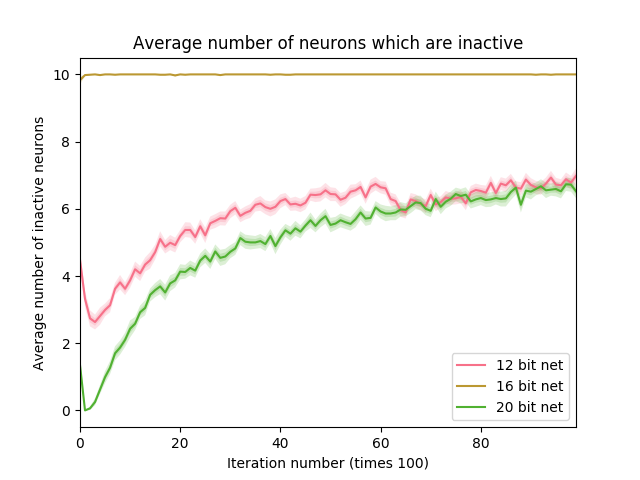

In [82]:
import activation_values
import itertools

# del(values12)
if "values12" not in globals():
    values12 = activation_values.test(12, 3, iter=10000, verbosity="none")
    values16 = activation_values.test(16, 3, iter=10000, verbosity="none")
    values20 = activation_values.test(20, 3, iter=10000, verbosity="none")

    sparsity12 = np.array([np.sum(x[1] == 0) for x in values12])
    sparsity16 = np.array([np.sum(x[1] == 0) for x in values16])
    sparsity20 = np.array([np.sum(x[1] == 0) for x in values20])


fig, ax1 = plt.subplots()
palette = itertools.cycle(sns.color_palette("husl"))

sns.tsplot(data=zigzag_data(sparsity12, (100, 100)), ci=[68, 95], ax=ax1, color=next(palette))
sns.tsplot(data=zigzag_data(sparsity16, (100, 100)), ci=[68, 95], ax=ax1, color=next(palette))
sns.tsplot(data=zigzag_data(sparsity20, (100, 100)), ci=[68, 95], ax=ax1, color=next(palette))

plt.title("Average number of neurons which are inactive")
plt.xlabel("Iteration number (times 100)")
plt.ylabel("Average number of inactive neurons")

ax1.legend(handles=ax1.lines[:], labels=["12 bit net", "16 bit net", "20 bit net"])

# Tada! The 16 bit neurons aren't learning as they are inactive from the very start.

Perhaps initializing only positive weights will help?

<IPython.core.display.Javascript object>


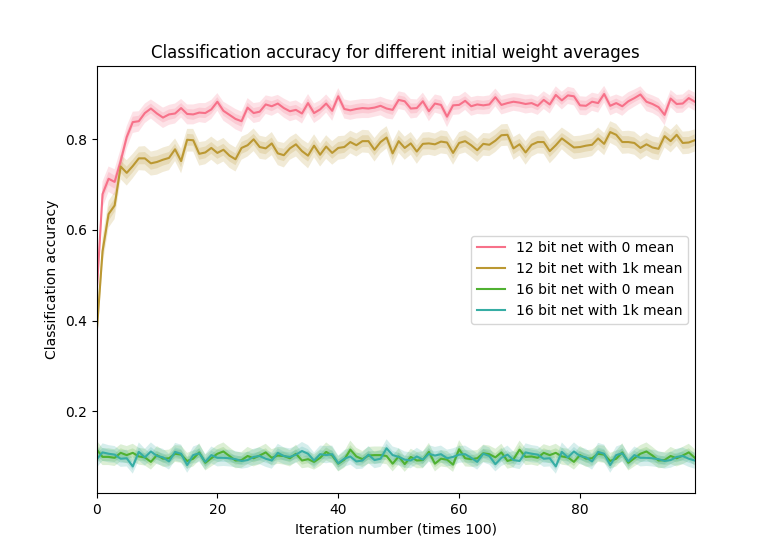

In [103]:
import mnist_int

# del class12_w0
if "class12_w0" not in globals():
    _, class12_w0  = mnist_int.test(12, 3, weight_mean=1000, weight_variance=500, iter=100000, verbosity='none')
    _, class12_w1k = mnist_int.test(12, 3, weight_mean=1000, weight_variance=500, iter=100000, verbosity='none')
    _, class16_w0  = mnist_int.test(16, 3, weight_mean=1000, weight_variance=500, iter=100000, verbosity='none')
    _, class16_w1k = mnist_int.test(16, 3, weight_mean=1000, weight_variance=500, iter=100000, verbosity='none')

    class12_w0  = np.array(class12_w0)    
    class12_w1k = np.array(class12_w1k)    
    class16_w0  = np.array(class16_w0)    
    class16_w1k = np.array(class16_w1k)    

    
fig, ax1 = plt.subplots()
palette = itertools.cycle(sns.color_palette("husl"))

sns.tsplot(data=zigzag_data(class12_w0,  (100, 1000)), ci=[68, 95], ax=ax1, color=next(palette))
sns.tsplot(data=zigzag_data(class12_w1k, (100, 1000)), ci=[68, 95], ax=ax1, color=next(palette))
sns.tsplot(data=zigzag_data(class16_w0,  (100, 1000)), ci=[68, 95], ax=ax1, color=next(palette))
sns.tsplot(data=zigzag_data(class16_w1k, (100, 1000)), ci=[68, 95], ax=ax1, color=next(palette))


plt.title("Classification accuracy for different initial weight averages")
plt.xlabel("Iteration number (times 100)")
plt.ylabel("Classification accuracy")

ax1.legend(handles=ax1.lines[:], labels=["12 bit net with 0 mean", "12 bit net with 1k mean", "16 bit net with 0 mean", "16 bit net with 1k mean"])

## As we can see, the 12 bit networks manage to train with weight initialized around both 0 and 1000, while the 16 bit networks fail to train at all, guessing randomly. 


# Hypothesis: 
Since networks use ReLU instead of Softmax, they have a lower activation bound (0), but not a higher one. This can cause the error to go to infinity, which is not the case for softmax or sigmoids. ** Thus, the network prefers to go to 0, as this way the error is at least bounded. This may be due to the bitwidth being "on the same wavelength" as the learning rate. ** As we change the LR, we see that the ridge shifts, which supports this theory.

## Lets test out:
* Whether leaky ReLU or softmax help
* Whether this is behavior is repeated over different datasets

## Leaky ReLU performance 
## TODO: add softmax

<IPython.core.display.Javascript object>


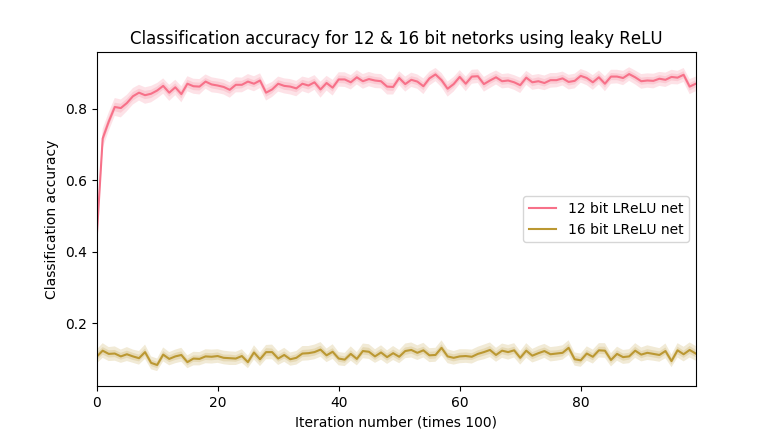

In [36]:
import mnist_int
from activations import leaky_relu, leaky_relu_derivative

if accuracy16 not in globals():
    _, accuracy16 = mnist_int.test(16, 3, func=leaky_relu, func_der=leaky_relu_derivative, iter=100000, verbosity="none")
    _, accuracy12 = mnist_int.test(12, 3, func=leaky_relu, func_der=leaky_relu_derivative, iter=100000, verbosity="none")

fig, ax1 = plt.subplots()
palette = itertools.cycle(sns.color_palette("husl"))

sns.tsplot(data=zigzag_data(np.array(accuracy12), (100, 1000)), ci=[68, 95], ax=ax1, color=next(palette))
sns.tsplot(data=zigzag_data(np.array(accuracy16), (100, 1000)), ci=[68, 95], ax=ax1, color=next(palette))

plt.title("Classification accuracy for 12 & 16 bit netorks using leaky ReLU")
plt.xlabel("Iteration number (times 100)")
plt.ylabel("Classification accuracy")

ax1.legend(handles=ax1.lines[:], labels=["12 bit LReLU net", "16 bit LReLU net"])


### Again, as we can see, there is something specific about 16 bits and LR 1/8 preventing the network from training. 

<IPython.core.display.Javascript object>


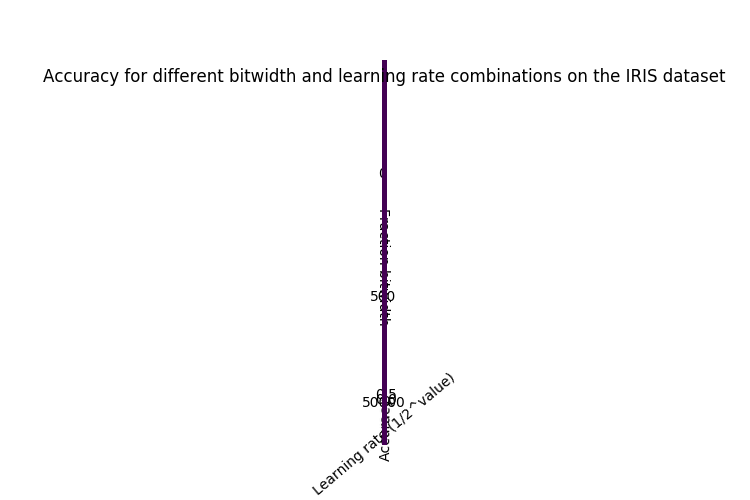

In [235]:
import iris_int
reload(iris_int)

iris_test = load_object("iris_test.pickle")
if not iris_test:
    accuracies = []
    fractions  = []
    rates      = []
    for fraction in range(0, 32):
        for lr in range(-5, 25):
            print ("trying fraction {} with LR {}".format(fraction, lr))
            acc, _ = iris_int.test(fraction, lr, iter=10000, func=linear, func_der=linear_derivative, verbosity='none')
            accuracies.append(acc)
            fractions.append(fraction)
            rates.append(lr)
    
    accuracies = np.array(accuracies).reshape(32, 30)
    fractions  = np.array(fractions).reshape(32, 30)
    rates      = np.array(rates).reshape(32, 30)
    
    save_object((accuracies, fractions, rates), "iris_test.pickle")
        
fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(fractions, rates, accuracies, cmap=matplotlib.cm.coolwarm, linewidth=1, antialiased=True)

ax.set_ylabel("Learning rate (1/2^value)")
ax.set_xlabel("Fraction bitwidth")
ax.set_zlabel("Accuracy")
plt.title ("Accuracy for different bitwidth and learning rate combinations on the IRIS dataset");


## While this graph is different from the MNIST one, we again see peculiar behavior for bitwidths in [15, 25] and LR in [15, 25].


## Let's test out one more dataset: the DIGITS dataset

13882289737.2
18035578196.2
14814475099.3
8826652243.82
17738116862.4
108350802.02
294754822.006
15542987783.1
14718918078.7
12710476192.8
10823289011.6
48675004.0393
15690920862.3
16422225131.5
15465468467.3
12092558533.5
363497956.387
20484763973.0
301701447.857
11306243720.9
650893801.86
18813354301.7
14669525950.8
14431679811.4
122158942.12
118084592.537
13772537932.4
303083297.341
22883313585.2
7475815832.89
16878323110.8
20222112661.8
273766578.913
18319958607.4
8926457099.55
11273527177.1
645304067.161
16379322106.6
208727420.545
233122707.973
322889668.735
17250751205.2
15886619729.8
19065675679.9
17976114245.5
486295955.122
415073000.992
15207149842.4
12271435666.8
15200015117.5
190677989.798
64433852.9429
14327263717.3
13785150852.3
550409391.868
27031721.4122
17077267353.0
132263311.107
252377391.584
610550487.619
20040919455.5
14581332034.7
850472837.073
28441117343.9
16468564703.2
14899208258.6
549685959.967
22321912968.3
137082802.334
11833947997.1
60132233.8997
210035797

16106580112.8
10437916572.9
22628958761.9
5255584445.4
10910291339.1
9836060643.97
20392764091.3
14528700737.3
11955456666.4
16278393510.8
7913257304.12
14097426285.1
7530330736.8
18965896457.5
12402014249.3
21669966535.6
10225200028.3
862175877.438
13540042901.2
1436637840.11
1217608293.03
13938076484.3
14497503279.2
4701187558.21
2729398822.03
15887978179.0
2758797216.95
528798725.407
9459330278.47
11715881037.3
24017633482.5
14741739218.8
11563342616.3
14479031767.0
1200818307.01
10426737628.3
10426227550.7
12355701615.0
11968648661.4
9463523438.44
24351965580.3
11752423117.0
16051550589.8
11884909630.1
17061732700.2
2020509118.4
18163311911.6
23696190023.9
10304805498.6
9167847383.18
17027459751.4
10538977077.8
21990790234.9
12307936987.7
19167114178.0
13953324145.0
15448150245.7
22046386861.4
19773561772.4
18113426052.8
28084130956.6
21773110901.1
4018048810.47
981186142.146
6929732344.3
12688065817.2
8470622875.14
1648928045.32
24386352242.8
1263873594.92
19555122873.5
1208435780

<IPython.core.display.Javascript object>


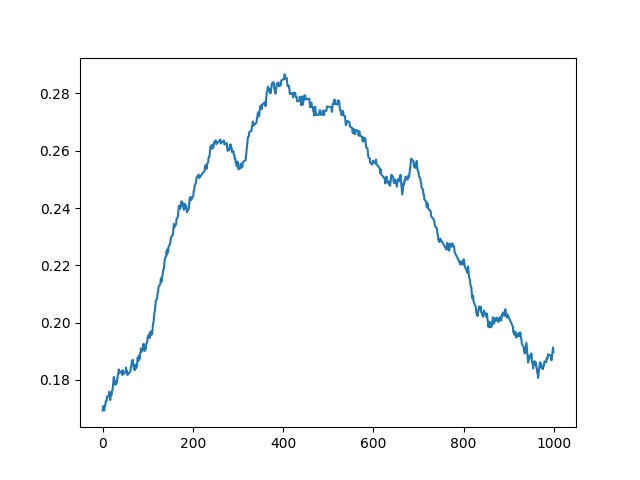

In [401]:
from sklearn.datasets import load_digits, fetch_mldata
# digits = load_digits()
# inputs  = digits['data'] / 16.0
# targets = digits['target']

mnist = fetch_mldata("MNIST original")
inputs = mnist.data / 255.0
targets = mnist.target

cls = train_integers.test_classification(inputs, targets, fraction=20, lr=10000, conf=[784, 10], 
          iter=1000, smooth_window=1001, func=relu, func_der=relu_derivative, verbosity="none")

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(cls)

In [384]:
fraction = 20
lr = 10
conf = [784, 10]
iter=100000
smooth_window=1001
func=relu
func_der=relu_derivative
verbosity="none"
weight_variance = 500

mnist = fetch_mldata('MNIST original')

#x = (mnist['data'] * 2**(fraction-8)).astype(int)
x = ((mnist.data / 255.0) * (2**fraction)).astype(int)
y = np.zeros((len(x), 10))
y[np.arange(len(x)).astype(int), mnist['target'].astype(int)] = 2**fraction

shuffle = np.random.permutation(np.arange(len(x)))
x = x[shuffle]
y = y[shuffle].astype(int)

MAX_SAMPLES = len(x)

w = np.random.normal(0, weight_variance, (10, 784))
w = np.rint(w).astype(int)

accuracy = []
classifications = np.zeros(1000)

for i in range(iter): 
    sample = i % MAX_SAMPLES
    z0 = x[sample]

    target = y[sample]

    z1 = np.matmul(w, z0)
    z1 = np.right_shift(z1, fraction)
    a1 = func(z1)
    
    #error = np.sum(np.abs(target - a1))

    delta = (target - a1) * func_der(z1)
    delta = np.round(delta).astype(int)

    # updates = z0.reshape(len(z0), 1) * delta.reshape(1, len(delta))
    updates = delta.reshape(len(delta), 1) * z0.reshape(1, len(z0))
    updates = np.right_shift(updates, fraction+lr)
    # updates = updates / 1000

    w = w + updates

    classifications[i % 1000] = np.argmax(a1) == np.argmax(target)
    accuracy.append(np.mean(np.argmax(a1) == np.argmax(target)))

    if verbosity == "low":
        print("accuracy: {}".format(np.mean(classifications)))

print np.mean(classifications)


0.895
